# Heat Stress
This breaks down each contribution to the theoretical scaling factor.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import numpy_indexed.index
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.circulation import get_u_thermal
from isca_tools.utils.constants import g, R, radius_earth, rot_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean, time_rolling

In [3]:
def get_angular_mom(u, lat, omega=rot_earth, radius=radius_earth):
    cos_lat = np.cos(np.deg2rad(lat))
    return (u+omega*radius*cos_lat)*radius_earth*cos_lat

def get_u_from_angular_mom(ang_mom, lat, omega=7.2921150e-05, radius=radius_earth):
    cos_lat = np.cos(np.deg2rad(lat))
    return ang_mom/radius_earth/cos_lat - omega*radius*cos_lat

In [4]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)
p_surface_approx = np.inf          # Desired approximate pressure of surface (hPa)

# Load dataset
# exp_dir = 'rossbypalooza/lat_20/'
# exp_names = ['0_25', '0_5', '1', '2', '4']
# time_start = 100
# time_final = 9999999999999999
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/'
exp_names = ['rot_0_25x', 'rot_0_5x', 'base', 'rot_1_5x', 'rot_2x', 'rot_4x']
time_start = 0
time_final = 9999999999999999
smooth_ndays = 20       # take rolling average in time dimension over this many days


# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'ucomp', 'omega']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']
# rot_rate = [1, 2]
n_exp = len(exp_names)
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
ds_base = []
ds = []
albedo = []
tau_sw = []
tau_lw = []
omega = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        try:
            omega += [namelist['constants_nml']['omega']]
        except KeyError:
            omega += [rot_earth]  # default earth value
        
        ds_base += [isca_tools.load_dataset(exp_dir + exp_names[j]).sel(time=slice(time_start, time_final))[var_keep]]
        
        # # Compute thermal wind
        # var_use_upper_ind = int(np.abs(ds_base[j].pfull - pressure_ft).argmin())
        # var_use = annual_mean(ds_base[j].temp.isel(pfull=slice(var_use_upper_ind, -1)).mean(dim='lon')).load()
        # var_use = var_use[:, ::-1]      # invert pressure coordinate so 1st is surface
        # var_use = var_use.transpose('pfull', 'lat', 'time')     # make time last axis
        # var_use[:] = get_u_thermal(var_use, var_use.pfull*100, var_use.lat)     # keep time and lat info by setting each pfull to same array
        
        ds_use = ds_base[j].sel(pfull=[p_surface_approx, pressure_ft], method='nearest')      # only keep the surface and free troposphere values
        ds_use['ang_mom'] = get_angular_mom(ds_use.ucomp, ds_use.lat, omega[j])
        ds_use['mse_surf'] = moist_static_energy(ds_use.temp.isel(pfull=0), ds_use.sphum.isel(pfull=0), ds_use.height.isel(pfull=0))
        ds_use['mse_ft_sat'] = moist_static_energy(ds_use.temp.isel(pfull=1), sphum_sat(ds_use.temp.isel(pfull=1), 
                                                                                        ds_use.pfull.isel(pfull=1)*100), 
                                                   ds_use.height.isel(pfull=1))  
        ds_use['mse_lapse'] = ds_use['mse_surf'] - ds_use['mse_ft_sat']
        ds_use = annual_mean(ds_use).mean(dim='lon')        # only keep annual mean
        
        # # all pressure levels of var_use are the same
        # ds_use['u_thermal'] = var_use.isel(pfull=0).transpose('time', 'lat') + \
        #                       ds_use.ucomp[:, 0]        # add surface wind as thermal only gives difference between levels
        # ind_eq = int(np.abs(ds_use.lat).argmin())
        # ds_use['u_ang_mom'] = get_u_from_angular_mom(ds_use.ang_mom.isel(lat=ind_eq), ds_use.lat, omega[j]) # zonal wind that conserves equatorial ang mom
        # 
        # ds_use['ang_mom_thermal'] = get_angular_mom(ds_use.u_thermal, ds_use.lat, omega[j])
        ds_use['ang_mom_u0'] = get_angular_mom(0, ds_use.lat, omega[j])
        if smooth_ndays > 1:
            ds_use = time_rolling(ds_use, smooth_ndays)
        ds += [ds_use.load()]          
        pbar.update(1)
omega = np.asarray(omega)        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:52: UserWarning: First mo

In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
if n_exp == 4:
    color_seq_rot = [default_colors[0], 'k', default_colors[1], default_colors[3]]
elif n_exp == 5:
    color_seq_rot = [default_colors[0], default_colors[2], 'k', default_colors[1], default_colors[3]]
elif n_exp == 6:
    color_seq_rot = [default_colors[0], default_colors[2], 'k', default_colors[1], 'lightcoral', 'maroon']
else:
    color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
ax_linewidth = plt.rcParams['axes.linewidth']
omega_earth_multiple = ['{:g}'.format(float('{:.2g}'.format(i))) for i in omega/rot_earth]      # multiple of earths rotation rate

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
n_days_year = ds[0].time.size

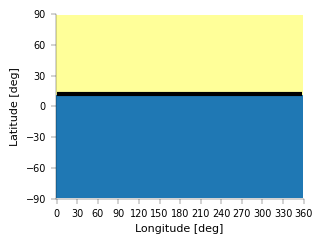

In [6]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    lat_land_ind = np.where(ds[0].lat>=lat_land_min-0.5)[0]
    lat_land_ind = lat_land_ind[np.where(ds[0].lat[lat_land_ind]<=lat_land_max+0.5)[0]]
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)
else:
    lat_land_min = None
    lat_land_max = None
    lat_land_ind = None

def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

## Amplification of max MSE relative to equator
Below I plot how the MSE amplification relative to the equator evolves throughout the year.

In [7]:
lat_eq_max = 5      # equatorial value is between +/- 5 degrees
def get_eq_value(dataset, lat_eq_max=lat_eq_max):
    return dataset.sel(lat=slice(-lat_eq_max, lat_eq_max)).mean(dim='lat')

In [8]:
# get maximum NH mse and latitude where it occurs
mse_max = np.zeros((n_exp, n_days_year))
mse_ft_sat_max = np.zeros((n_exp, n_days_year))
lat_mse_max = np.zeros((n_exp, n_days_year))
lat_mse_ft_sat_max = np.zeros((n_exp, n_days_year))
lat_hemisphere = {'n': slice(lat_eq_max, 90), 's': slice(-90, -lat_eq_max)}
hemisphere_plot = 'n'
for i in range(n_exp):
    mse_max[i] = ds[i].mse_surf.sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat')
    mse_ft_sat_max[i] = ds[i].mse_ft_sat.sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat')
    lat_mse_max[i] = ds[i].lat.sel(lat=lat_hemisphere[hemisphere_plot])[ds[i].mse_surf.sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')]
    lat_mse_ft_sat_max[i] = ds[i].lat.sel(lat=lat_hemisphere[hemisphere_plot]
                                          )[ds[i].mse_ft_sat.sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')]

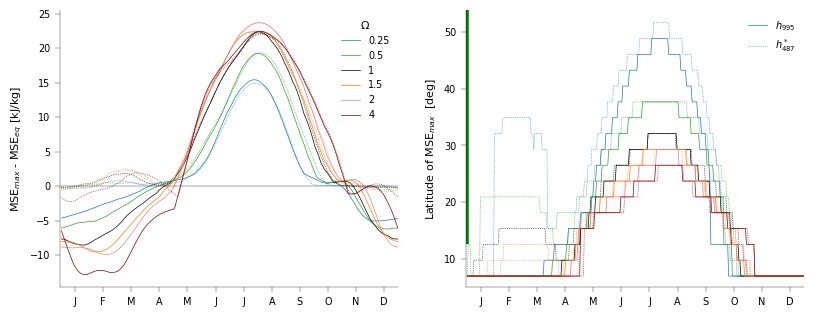

In [9]:
save_mse_amp_timeseries_fig = False
label_mse_surf = "$h_{"+f"{p_surface/100:.0f}"+"}$"
label_mse_ft = "$h^*_{"+f"{pressure_ft_actual/100:.0f}"+"}$"
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[i].time, mse_max[i] - get_eq_value(ds[i].mse_surf), 
               color=color_seq_rot[i], label=omega_earth_multiple[i])
    ax[0].plot(ds[i].time, mse_ft_sat_max[i] - get_eq_value(ds[i].mse_ft_sat), 
               color=color_seq_rot[i], linestyle=':')
    ax[1].plot(ds[i].time, lat_mse_max[i], 
               color=color_seq_rot[i], label=label_mse_surf if i==0 else None)
    ax[1].plot(ds[i].time, lat_mse_ft_sat_max[i], 
               color=color_seq_rot[i], linestyle=':', label=label_mse_ft if i==0 else None)
ax[0].legend(title='$\Omega$')
ax[1].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_days_year)
if hemisphere_plot == 'n':
    ax[1].set_ylim(lat_eq_max, ax[1].get_ylim()[1])
else:
    ax[1].set_ylim(ax[1].get_ylim()[0], -lat_eq_max)
ax[0].set_ylabel('MSE$_{max}$ - MSE$_{eq}$ [kJ/kg]')
ax[1].set_ylabel('Latitude of MSE$_{max}$  [deg]')
show_land([ax[1]], lat_ax='y')
if save_mse_amp_timeseries_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_amp_timeseries.pdf", 
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Surface Temperature
Below I repeat the above plot to show that the effect of $\Omega$ on MSE amplification is similar to that on max temperature.

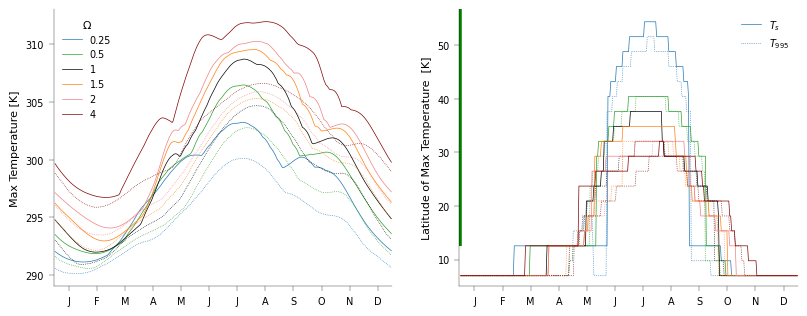

In [10]:
save_temp_max_fig = False
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[i].time, ds[i].t_surf.sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat'),
               color=color_seq_rot[i], label=omega_earth_multiple[i])
    ax[0].plot(ds[i].time, ds[i].temp.isel(pfull=ind_surf).sel(lat=lat_hemisphere[hemisphere_plot]).max(dim='lat'), 
               color=color_seq_rot[i], linestyle=':')
    ax[1].plot(ds[i].time, ds[i].lat.sel(lat=lat_hemisphere[hemisphere_plot])[
        ds[i].t_surf.sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')], 
               color=color_seq_rot[i], label='$T_s$' if i==0 else None)
    ax[1].plot(ds[i].time, ds[i].lat.sel(lat=lat_hemisphere[hemisphere_plot])[
        ds[i].temp.isel(pfull=ind_surf).sel(lat=lat_hemisphere[hemisphere_plot]).argmax(dim='lat')], 
               color=color_seq_rot[i], linestyle=':', label="$T_{"+f"{p_surface/100:.0f}"+"}$" if i==0 else None)
ax[1].legend()
ax[0].legend(title='$\Omega$')
ax[1].legend()
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(-1, n_days_year)
if hemisphere_plot == 'n':
    ax[1].set_ylim(lat_eq_max, ax[1].get_ylim()[1])
else:
    ax[1].set_ylim(ax[1].get_ylim()[0], -lat_eq_max)
ax[0].set_ylabel('Max Temperature [K]')
ax[1].set_ylabel('Latitude of Max Temperature  [K]')
show_land([ax[1]], lat_ax='y')
if save_temp_max_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_amp_timeseries.pdf", 
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Regime Transition
Below I plot the local maxima of precipitation over land and ocean to see when there is a regime change from having 2 cells with ascent over ocean and coastline, as indicated by distinct local maxima over ocean and land. To a single cell reigme with just one maxima over land.

I say the transition occurs when the local maxima over ocean moves into the southern hemisphere, and the single cell regime concludes when the ocean maxima moves back to the northern hemisphere.

In [11]:
precip_maxima = {key: np.zeros((n_exp, n_days_year)) for key in ['val_ocean', 'lat_ocean', 'val_land', 'lat_land']}
local_maxima_lat_min_dist = 6       # local maxima cannot be closer than this number of degrees in latitude
lat_land_ind_pad = np.pad(lat_land_ind, 1, 'constant', constant_values=(lat_land_ind[0]-1,lat_land_ind[-1]+1))  
for i in range(n_exp):
    # say land influences +/-1 grid points either side
    thresh_use = float(ds[i].precipitation.sel(lat=25, method='nearest').quantile(0.7))
    for j in range(n_days_year):
        var = scipy.signal.find_peaks(ds[i].precipitation.isel(time=j), 
                                      distance=int(np.round(local_maxima_lat_min_dist/np.median(np.ediff1d(ds[0].lat)))), 
                                      height=float(ds[i].precipitation.mean()))     # say local maxima must be larger than mean
        is_land_ind = numpy_indexed.indices(lat_land_ind_pad, var[0], missing=-1)>=0
        land_ind_use = var[0][is_land_ind]
        ocean_ind_use = var[0][~is_land_ind]
        if len(ocean_ind_use)>0:
            precip_maxima['val_ocean'][i, j] = ds[i].precipitation.isel(time=j, lat=ocean_ind_use).max()
            precip_maxima['lat_ocean'][i, j] = ds[i].lat[np.abs(ds[i].precipitation.isel(time=j)-precip_maxima['val_ocean'][i, j]).argmin()]
        else:
            precip_maxima['val_ocean'][i, j] = 0
            precip_maxima['lat_ocean'][i, j] = np.nan
        if len(land_ind_use)>0:
            precip_maxima['val_land'][i, j] = ds[i].precipitation.isel(time=j, lat=land_ind_use).max()
            precip_maxima['lat_land'][i, j] = ds[i].lat[np.abs(ds[i].precipitation.isel(time=j)-precip_maxima['val_land'][i, j]).argmin()]
        else:
            precip_maxima['val_land'][i, j] = 0
            precip_maxima['lat_land'][i, j] = np.nan

regime_change_times = np.zeros((n_exp, 2))
for i in range(n_exp):
    # 1 cell regime starts when local maxima over ocean first shifts from NH to SH
    regime_change_times[i, 0] = ds[i].time[np.where((precip_maxima['lat_ocean'][i]>0) & 
                                                    (np.gradient((precip_maxima['lat_ocean'][i]>0)*1)<0))[0][0] + 1]
    # 1 cell regime ends when local maxima over ocean shifts back from SH to NH
    regime_change_times[i, 1] = ds[i].time[np.where((precip_maxima['lat_ocean'][i]>0) & 
                                                    (ds[i].time.to_numpy()>regime_change_times[i, 0]))[0][0]]

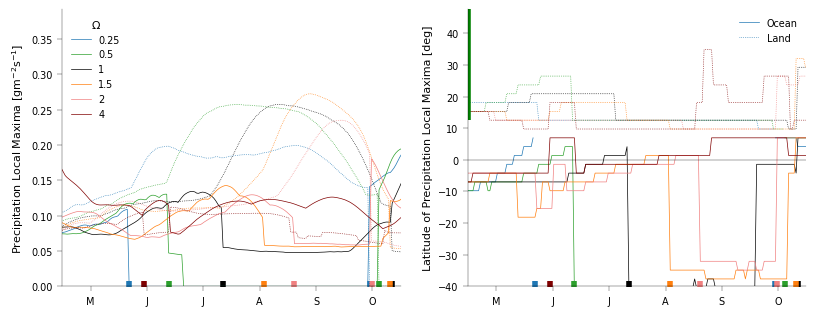

In [12]:
save_precip_local_maxima_fig = False
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[i].time, precip_maxima['val_ocean'][i]*1000, color=color_seq_rot[i], label=omega_earth_multiple[i])
    ax[0].plot(ds[i].time, precip_maxima['val_land'][i]*1000, color=color_seq_rot[i], linestyle=':')
    ax[1].plot(ds[i].time, precip_maxima['lat_ocean'][i], color=color_seq_rot[i], label='Ocean' if i==0 else None)
    ax[1].plot(ds[i].time, precip_maxima['lat_land'][i], color=color_seq_rot[i], linestyle=':', label='Land' if i==0 else None)
    ax[0].scatter(regime_change_times[i], [0, 0], color=color_seq_rot[i], marker='|', s=50, lw=4)
    ax[1].scatter(regime_change_times[i], [-40, -40], color=color_seq_rot[i], marker='|', s=50, lw=4)
ax[0].set_xticks(*month_ticks)
ax[0].set_xlim(120, 300)
ax[0].legend(title='$\Omega$')
ax[1].legend()
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[1].set_ylim(-40, ax[1].get_ylim()[1])
ax[1].axhline(0, color='k', lw=ax_linewidth)
show_land([ax[1]], lat_ax='y')
ax[0].set_ylabel('Precipitation Local Maxima [gm$^{-2}$s$^{-1}$]')
ax[1].set_ylabel('Latitude of Precipitation Local Maxima [deg]')
if save_precip_local_maxima_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/precip_local_maxima.pdf", 
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Max Hadley Cell Extent
This is to replicate Cox 2021 Figure 6 but with the maximum excursion of the MSE peak rather than the Hadley Cell Extent. The scaling compares pretty well to the theories for each of the possible extent indicators.

### Compute Hadley cell extent from $\omega_{500}$
Say Hadley cell ends at first latitude further north of latitude of maximum ascent where $\omega > thresh$ where $thresh$ is some small negative number. 

Do this for moving average of 5 latitudes so as to avoid effect of double peaks.

In [13]:
# Max Hadley cell extent by ascent at 500hPa
ascent_max = np.zeros((n_exp, n_days_year))
lat_ascent_max = np.zeros((n_exp, n_days_year))
lat_hadley_extent = np.full((n_exp, n_days_year), np.nan)
ascent_n_lat_av = 5
ascent_thresh_quant = 0.1               # A period has ascent if min omega less than this quantile of overall omega
ascent_thresh_multiplier = 0.1          # Edge of hadley cell is where omega is more positive than ascent_thresh multiplied by this
for i in range(n_exp):
    ascent_thresh = ds[i].omega.isel(pfull=ind_ft).sel(lat=slice(lat_eq_max, 90)).quantile(ascent_thresh_quant)
    for j in range(n_days_year):
        ascent_rolling = ds[i].omega.isel(pfull=ind_ft, time=j).rolling(lat=ascent_n_lat_av, center=True).mean()
        ascent_max_sh = ascent_rolling.sel(lat=slice(-90, -lat_eq_max)).min()       
        ascent_rolling = ascent_rolling.sel(lat=slice(lat_eq_max, 90))
        ascent_max[i, j] = ascent_rolling.min()
        lat_ascent_max[i, j] = ascent_rolling.lat[ascent_rolling.argmin()]
        # Only compute ascent if above a threshold and larger than sh peak ascent
        if ascent_max[i, j] < ascent_thresh and ascent_max[i, j] < ascent_max_sh:
            ind_max = int(ascent_rolling.argmin())
            ind_low_ascent = np.where(ascent_rolling>ascent_thresh * ascent_thresh_multiplier)[0]
            ind_use = ind_low_ascent[ind_low_ascent>ind_max][0]
            lat_hadley_extent[i, j] = ascent_rolling.lat[ind_use]
    

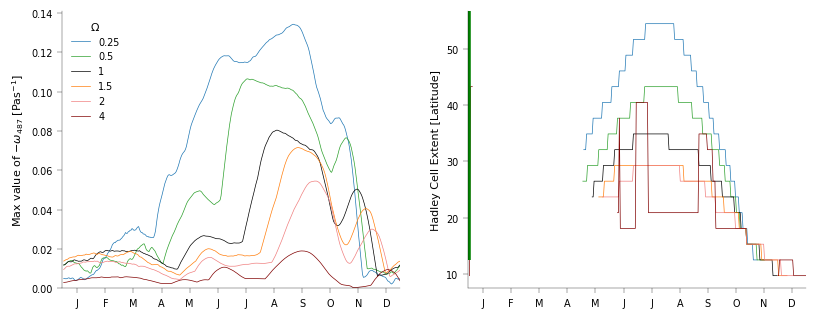

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds[0].time, -ascent_max[i], color=color_seq_rot[i], label=omega_earth_multiple[i])
    ax[1].plot(ds[0].time, lat_hadley_extent[i], color=color_seq_rot[i])
ax[0].legend(title='$\Omega$')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[0].set_xlim(-1, n_days_year)
show_land([ax[1]], lat_ax='y')
ax[0].set_ylabel("Max value of $-\omega_{"+f"{pressure_ft_actual/100:.0f}"+"}$ [Pas$^{-1}$]" )
ax[1].set_ylabel('Hadley Cell Extent [Latitude]');

In [15]:
time_max_extent = {key: np.zeros(n_exp) for key in ['mse', 'mse_ft_sat', 'ascent']}
for i in range(n_exp):
    # Account for multiple maxima by taking median time
    time_max_extent['mse'][i] = ds[i].time[np.where(lat_mse_max[i]==lat_mse_max[i].max())].median()
    time_max_extent['mse_ft_sat'][i] = ds[i].time[np.where(lat_mse_ft_sat_max[i]==lat_mse_ft_sat_max[i].max())].median()
    time_max_extent['ascent'][i] = ds[i].time[np.where(lat_hadley_extent[i]==np.nanmax(lat_hadley_extent[i]))].median()

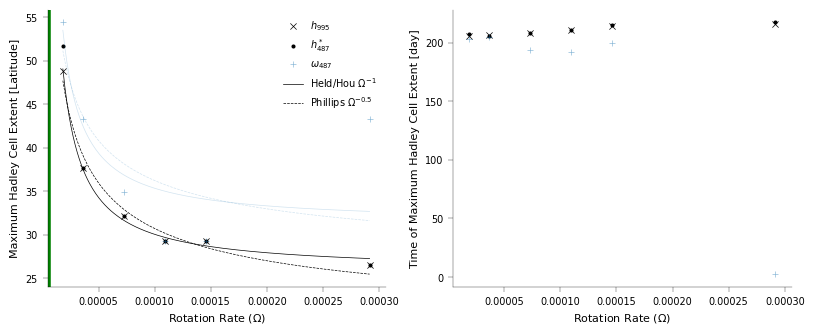

In [16]:
fit_omega_array = np.linspace(omega[0], omega[-1], 300)
show_ascent = True
fig, ax = plt.subplots(1, 2, figsize=(im_sz*2*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax[0].scatter(omega, lat_mse_max.max(axis=-1), color='k', marker='x', s=20, label=label_mse_surf)
ax[0].scatter(omega, lat_mse_ft_sat_max.max(axis=-1), color='k', marker='.', s=15, label=label_mse_ft)
if show_ascent:
    ax[0].scatter(omega, np.nanmax(lat_hadley_extent, axis=-1), color=default_colors[0], marker='+', s=20, 
               label="$\omega_{"+f"{pressure_ft_actual/100:.0f}"+"}$", alpha=0.5)

fit_params = np.polyfit(omega**(-1), lat_mse_max.max(axis=-1), 1)
ax[0].plot(fit_omega_array, fit_params[1] + fit_params[0]/fit_omega_array, color='k', label='Held/Hou $\Omega^{-1}$')
fit_params = np.polyfit(omega**(-0.5), lat_mse_max.max(axis=-1), 1)
ax[0].plot(fit_omega_array, fit_params[1] + fit_params[0]/fit_omega_array**0.5, color='k', linestyle='--', 
        label='Phillips $\Omega^{-0.5}$')

if show_ascent:
    fit_params = np.polyfit(omega**(-1), np.nanmax(lat_hadley_extent, axis=-1), 1)
    ax[0].plot(fit_omega_array, fit_params[1] + fit_params[0]/fit_omega_array, color=default_colors[0], alpha=0.2)
    fit_params = np.polyfit(omega**(-0.5), np.nanmax(lat_hadley_extent, axis=-1), 1)
    ax[0].plot(fit_omega_array, fit_params[1] + fit_params[0]/fit_omega_array**0.5, color=default_colors[0], linestyle='--', alpha=0.2)

ax[1].scatter(omega, time_max_extent['mse'], color='k', marker='x', s=20)
ax[1].scatter(omega, time_max_extent['mse_ft_sat'], color='k', marker='.', s=15)
if show_ascent:
    ax[1].scatter(omega, time_max_extent['ascent'], color=default_colors[0], marker='+', s=20, alpha=0.5)

ax[0].legend()
show_land([ax[0]], lat_ax='y')
ax[0].set_ylabel('Maximum Hadley Cell Extent [Latitude]')
ax[0].set_xlabel('Rotation Rate ($\Omega$)')
ax[1].set_xlabel('Rotation Rate ($\Omega$)')
ax[1].set_ylabel('Time of Maximum Hadley Cell Extent [day]');

## Free Tropospheric Profile At Time Of Max Extent
Below I plot $T_{500}$ at the time of max SH Hadlye extent. The idea is that the blue line looks a bit like the Lindzen Hou solution to a forcing similar to the red line.

Red line is large roation and shows what temperature profile would look like at this time in absense of dynamic influence - Hadley cell does not reach land.

Blue line is close to angular momentum conserving, with magnitude of peak similar in both hemispheres.

I guess the flatness in SH tropics of red line is due to weak temperature gradient effects.

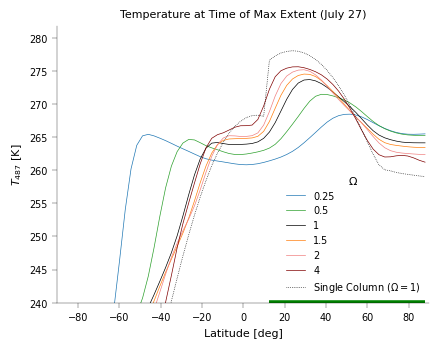

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax.plot(ds[0].lat, ds[i].temp.sel(time=time_max_extent['mse'][0], method='nearest').isel(pfull=ind_ft), 
            color=color_seq_rot[i], label=omega_earth_multiple[i])
ax.plot(ds_sc.lat, ds_sc.temp.sel(time=time_max_extent['mse'][0], method='nearest').sel(pfull=pressure_ft_actual/100, method='nearest'),
        color='k', linestyle=':', label='Single Column ($\\Omega=1$)')
ax.legend(title='$\Omega$')
ax.set_ylabel(label_mse_ft.replace('h^*', 'T') + ' [K]')
ax.set_xlabel('Latitude [deg]')
ax.set_xlim(-90, 90)
ax.set_ylim(240, ax.get_ylim()[1])

show_land([ax])
ax.set_title(f"Temperature at Time of Max Extent "
             f"({month_names[int(np.floor(time_max_extent['mse'][0]/30))]} {int(np.median(time_max_extent['mse'][0])%30+1)})");

In [69]:
# Single column stuff
exp_dir_sc = 'rossbypalooza/depth=20/all_nh/lat_10/column/base/'
var_keep_sc = ['temp', 'sphum', 'height', 't_surf', 'precipitation']
ds_sc = isca_tools.load_dataset(exp_dir_sc).sel(time=slice(time_start*0, time_final*np.inf))[var_keep_sc]
ds_sc = ds_sc.isel(lon=0).load()

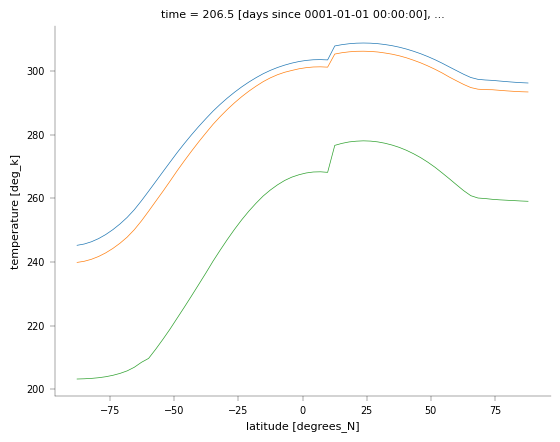

In [86]:
ds_sc.t_surf.sel(time=time_max_extent['mse'][0], method='nearest').plot()
ds_sc.temp.sel(time=time_max_extent['mse'][0], method='nearest').sel(pfull=pressure_ft_actual, method='nearest').plot()
ds_sc.temp.sel(time=time_max_extent['mse'][0], method='nearest').sel(pfull=pressure_ft, method='nearest').plot()

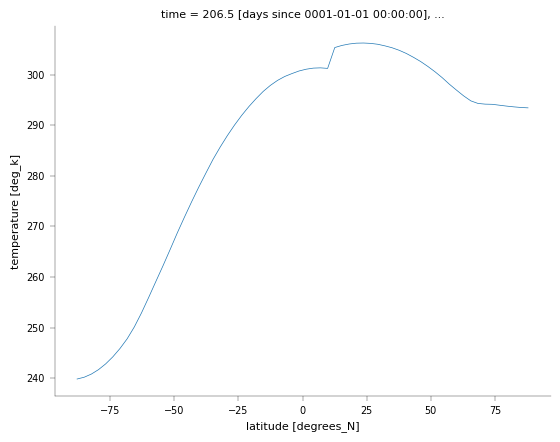

In [103]:
ds_sc.temp.sel(time=time_max_extent['mse'][0], method='nearest').sel(pfull=pressure_ft, method='nearest').plot()

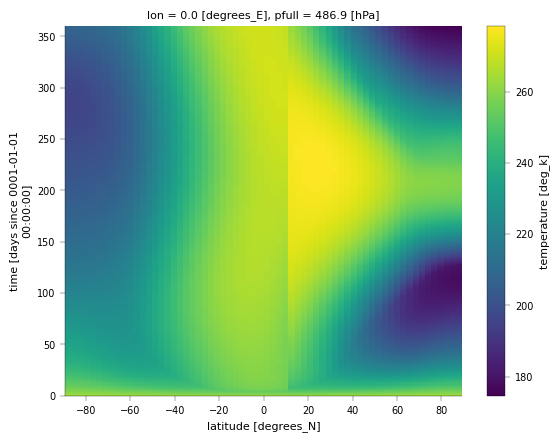

In [90]:
ds_sc.temp.sel(pfull=pressure_ft, method='nearest').plot()

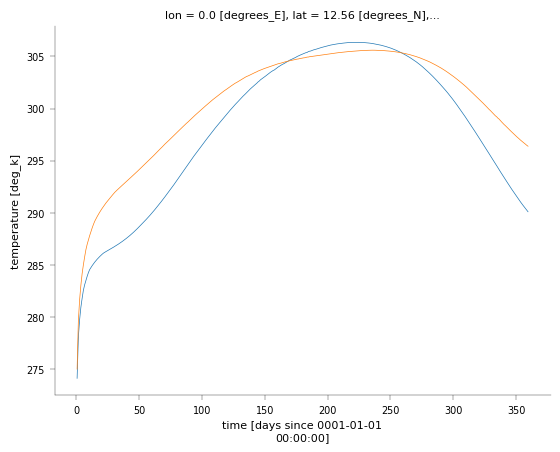

In [105]:
ds_sc.temp.sel(pfull=pressure_ft*1000, method='nearest').sel(lat=20, method='nearest').plot()
ds_sc.temp.sel(pfull=pressure_ft*1000, method='nearest').sel(lat=12, method='nearest').plot()